# Data Analysis & Visualization

This notebook fetches data from the Analytics API to visualize engagement patterns and author performance. The goal is to derive actionable insights based on the data.

**Visualizations:**
1.  Trend of engagement by author & category over time
2.  Heatmap of engagement by hour/day
3.  Scatter plot: volume vs engagement per post


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")
BASE_URL = "http://localhost:3000/api"


## 1. Trend of Engagement by Author & Category Over Time

This line chart shows the total number of engagements per week for different authors and categories over the last 3 months. It helps us identify which content areas are growing and which authors are maintaining consistent engagement.


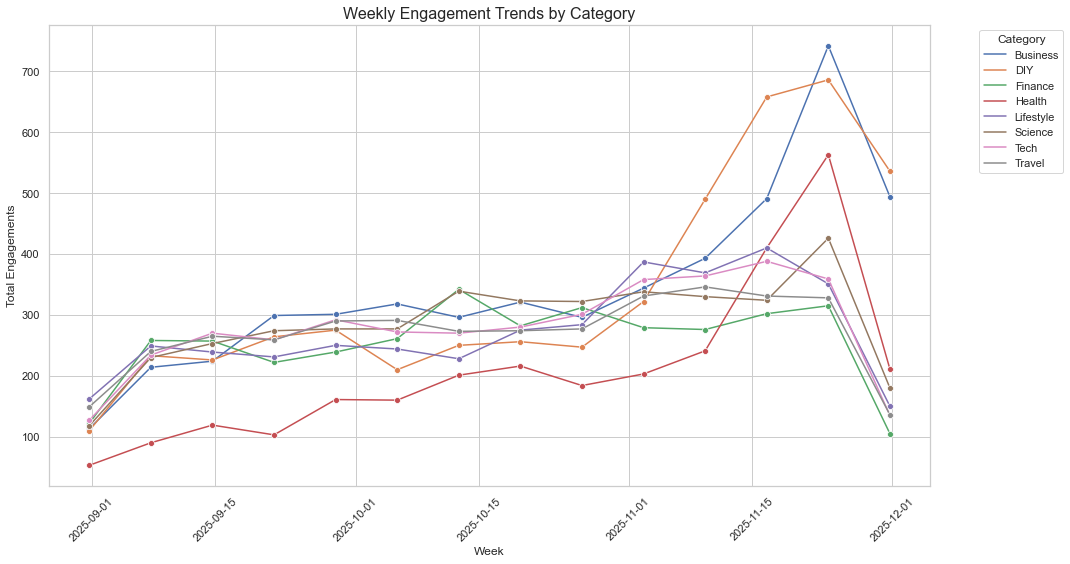

In [13]:
try:
    res = requests.get(f"{BASE_URL}/analysis/engagement-over-time")
    data = res.json()
    df_trends = pd.DataFrame(data)
    
    # --- FIX: Convert data types ---
    df_trends['week'] = pd.to_datetime(df_trends['week'])
    df_trends['total_engagements'] = pd.to_numeric(df_trends['total_engagements'])
    df_trends['category'] = df_trends['category'].astype(str)
    # --- END FIX ---
    
    # --- SIMPLIFICATION: Group by category instead of individual authors ---
    df_category_trends = df_trends.groupby(['week', 'category'])['total_engagements'].sum().reset_index()
    # --- END SIMPLIFICATION ---

    plt.figure(figsize=(15, 8))
    # Plot the aggregated data
    sns.lineplot(data=df_category_trends, x='week', y='total_engagements', hue='category', marker='o')
    
    plt.title('Weekly Engagement Trends by Category', fontsize=16)
    plt.xlabel('Week')
    plt.ylabel('Total Engagements')
    plt.xticks(rotation=45)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

except requests.exceptions.ConnectionError as e:
    print("Error: Could not connect to the API. Please ensure the server is running.")
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")
    if 'df_trends' in locals() and df_trends.empty:
        print("The API returned no data for this query.")


## 2. Heatmap of Engagement by Hour/Day

This heatmap visualizes the best times for engagement. The darker squares indicate a higher volume of engagements, helping us decide on the optimal schedule for publishing content.


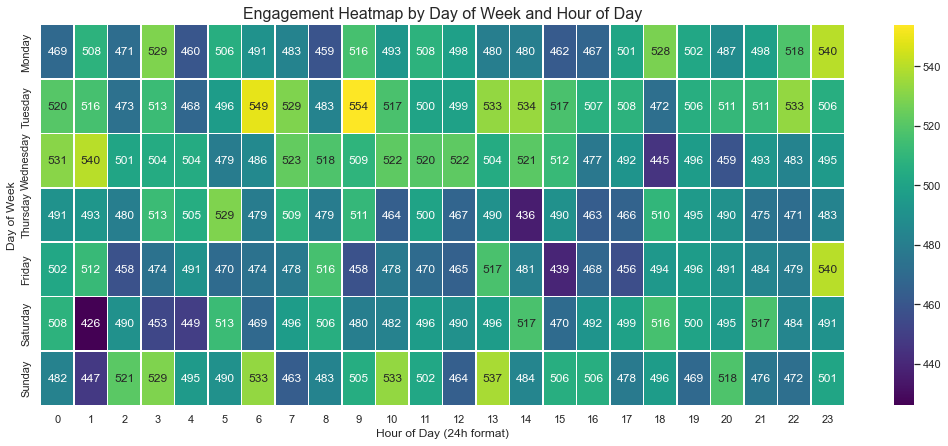

In [11]:
try:
    res = requests.get(f"{BASE_URL}/analysis/engagement-patterns")
    data = res.json()
    df_patterns = pd.DataFrame(data)

    # --- FIX: Convert data types ---
    # Ensure all relevant columns are numeric to prevent aggregation errors
    df_patterns['day_of_week'] = pd.to_numeric(df_patterns['day_of_week'])
    df_patterns['hour_of_day'] = pd.to_numeric(df_patterns['hour_of_day'])
    df_patterns['total_engagements'] = pd.to_numeric(df_patterns['total_engagements'])
    # --- END FIX ---

    # The API returns DOW where Sunday=0, Monday=1, etc. Let's map it to day names.
    day_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
    df_patterns['day_of_week'] = df_patterns['day_of_week'].map(day_map)
    
    # Pivot the data to create a matrix for the heatmap
    heatmap_data = df_patterns.pivot_table(index='day_of_week', columns='hour_of_day', values='total_engagements')
    
    # Order the days of the week correctly
    heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    plt.figure(figsize=(18, 7))
    sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".0f", linewidths=.5)
    
    plt.title('Engagement Heatmap by Day of Week and Hour of Day', fontsize=16)
    plt.xlabel('Hour of Day (24h format)')
    plt.ylabel('Day of Week')
    plt.show()

except requests.exceptions.ConnectionError as e:
    print("Error: Could not connect to the API. Please ensure the server is running.")
except Exception as e:
    print(f"An error occurred: {e}")
    if 'df_patterns' in locals() and df_patterns.empty:
        print("The API returned no data for this query.")


## 3. Scatter Plot: Post Volume vs. Engagement per Post

This scatter plot helps us identify different types of authors:
-   **Top-Right (High Volume, High Engagement):** Star performers.
-   **Top-Left (Low Volume, High Engagement):** Quality over quantity. Potential to grow.
-   **Bottom-Right (High Volume, Low Engagement):** Potentially creating low-quality or "spammy" content. Need investigation.
-   **Bottom-Left (Low Volume, Low Engagement):** New or inactive authors.


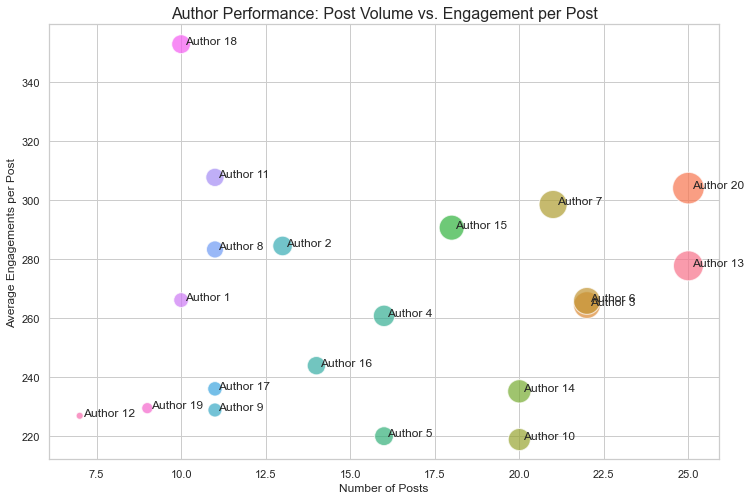

In [12]:
try:
    res = requests.get(f"{BASE_URL}/analysis/low-engagement-authors")
    data = res.json()
    df_authors = pd.DataFrame(data)
    
    # --- FIX: Convert data types ---
    df_authors['post_count'] = pd.to_numeric(df_authors['post_count'])
    df_authors['engagement_per_post'] = pd.to_numeric(df_authors['engagement_per_post'])
    df_authors['total_engagements'] = pd.to_numeric(df_authors['total_engagements'])
    # --- END FIX ---
    
    plt.figure(figsize=(12, 8))
    plot = sns.scatterplot(
        data=df_authors,
        x='post_count',
        y='engagement_per_post',
        size='total_engagements',  # Bubble size represents total engagement
        hue='name',               # Color represents the author
        sizes=(50, 1000),         # Range of bubble sizes
        alpha=0.7,
        legend=False
    )
    
    # Add labels for each point
    for i in range(df_authors.shape[0]):
        plt.text(
            x=df_authors.post_count[i] + 0.1, 
            y=df_authors.engagement_per_post[i], 
            s=df_authors.name[i]
        )

    plt.title('Author Performance: Post Volume vs. Engagement per Post', fontsize=16)
    plt.xlabel('Number of Posts')
    plt.ylabel('Average Engagements per Post')
    plt.grid(True)
    plt.show()

except requests.exceptions.ConnectionError as e:
    print("Error: Could not connect to the API. Please ensure the server is running.")
except Exception as e:
    print(f"An error occurred: {e}")
    if 'df_authors' in locals() and df_authors.empty:
        print("The API returned no data for this query.")
